In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import clip
import matplotlib.pyplot as plt
import tqdm
from PIL import Image

In [10]:
# Load the model
device = "cpu"
model, preprocess = clip.load('ViT-B/32', device)
print(device)

cpu


In [19]:
print(os.path.expanduser("~/.cache"))
# Download the dataset
cifar10 = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False)

/home/clip/.cache
Files already downloaded and verified


In [274]:
def plot_cosine(count, similarity, texts, images):
    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    # plt.colorbar()
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x][0]:.4f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
      plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title(r"Cosine similarity between text and image features", size=20)

In [120]:
def calc_cosine(texts, images, device='cpu'):
    #Create inputs
    text_inputs = []
    image_inputs = []
    for text in texts:
        text_inputs.append(clip.tokenize(text))
    for img in images:
        image_inputs.append(preprocess(img).unsqueeze(0).to(device))
    #Calculate features and similarities
    similarity = []
    with torch.no_grad():
        for img in image_inputs:
            img_feat = model.encode_image(img)
            img_feat /= img_feat.norm(dim=-1, keepdim=True)
            sims = []
            for txt in text_inputs:
                txt_feat = model.encode_text(txt)
                txt_feat /= txt_feat.norm(dim=-1, keepdim=True)            
                sim = txt_feat.cpu().numpy() @ img_feat.cpu().numpy().T
                sims.append(sim[0])
            similarity.append(sims)
    similarity = np.array(similarity)
    return similarity

In [264]:
orig_arr = np.load("./12_1_orig.npy")
makeup_arr = np.load("./12_1_m3.npy")
glass_arr = np.load("./1_1_m3.npy")
orig_arr = (orig_arr + 1) / 2
makeup_arr = (makeup_arr + 1) / 2
glass_arr = (glass_arr + 1) / 2

In [265]:
orig_img = Image.fromarray((orig_arr* 255).astype(np.uint8))
makeup_img = Image.fromarray((makeup_arr* 255).astype(np.uint8))
glass_img = Image.fromarray((glass_arr* 255).astype(np.uint8))

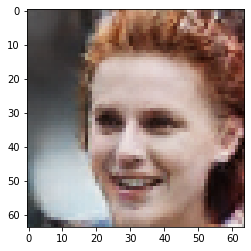

In [261]:
plt.imshow(orig_img)

In [267]:
text1 = "woman with red hair"
text2 = "woman with red lipstick and blonde hair"
text3 = "woman with sunglasses"
texts = [text1, text2, text3]
images = [orig_img, makeup_img, glass_img]
similarity = calc_cosine(texts, images)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


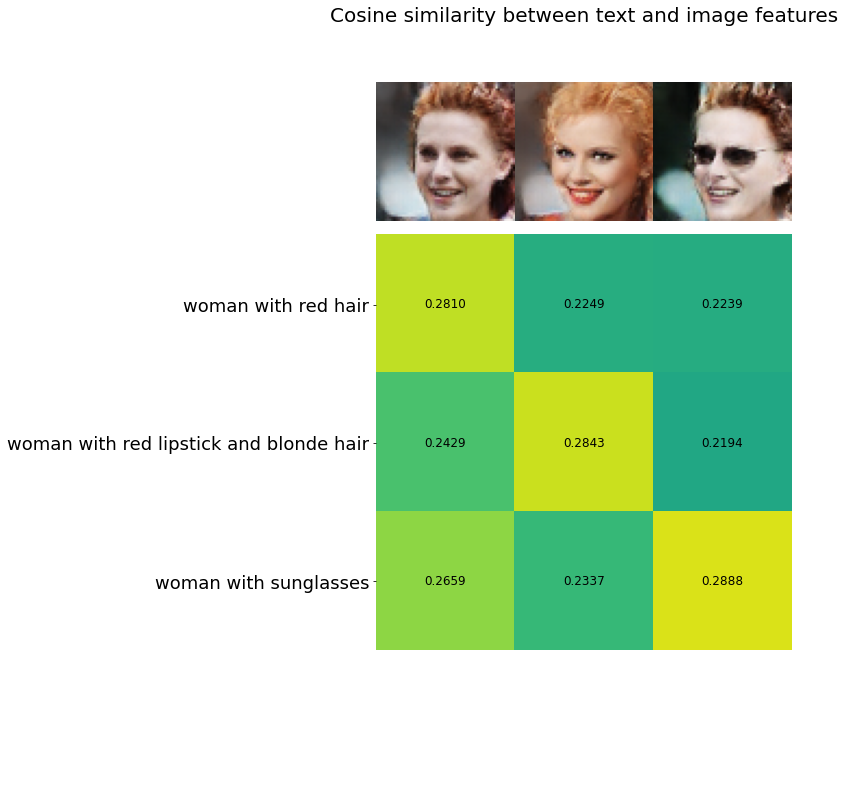

In [272]:
arrays = [orig_arr, makeup_arr, glass_arr]

plot_cosine(3, similarity, texts, arrays)